In [1]:
!pip install xgboost --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, median_absolute_error

In [3]:
df = pd.read_csv('/content/pollution_2000_2023.csv')

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (86141, 22)
   Unnamed: 0        Date                                  Address    State  \
0           0  2000-01-01  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
1           1  2000-01-02  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
2           2  2000-01-03  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
3           3  2000-01-04  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
4           4  2000-01-05  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   

     County     City   O3 Mean  O3 1st Max Value  O3 1st Max Hour  O3 AQI  \
0  Maricopa  Phoenix  0.019765             0.040               10      37   
1  Maricopa  Phoenix  0.015882             0.032               10      30   
2  Maricopa  Phoenix  0.009353             0.016                9      15   
3  Maricopa  Phoenix  0.015882             0.033                9      31   
4  Maricopa  Phoenix  0.007353             0.012                9      11   

   ...  CO 1st Max Hour  CO AQI  SO

Convert date column and feature engineering

In [4]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract year, month, day, weekday from date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday

Handle missing values

In [5]:
# Check missing values
print("Missing values:\n", df.isnull().sum())

# Target pollutant column to predict
target = 'O3 Mean'  # You can change this to CO Mean, SO2 Mean, etc.

# List features to use (all pollutant means except target + date parts)
pollutants = ['CO Mean', 'SO2 Mean', 'NO2 Mean']  # Add/remove based on what is available
features = pollutants + ['Year', 'Month', 'Day', 'Weekday']

# Drop rows with missing target or features
df = df.dropna(subset=[target] + pollutants)

# Fill missing values in features with median (if any)
for col in pollutants:
    df[col].fillna(df[col].median(), inplace=True)

Missing values:
 Unnamed: 0           0
Date                 0
Address              0
State                0
County               0
City                 0
O3 Mean              0
O3 1st Max Value     0
O3 1st Max Hour      0
O3 AQI               0
CO Mean              1
CO 1st Max Value     1
CO 1st Max Hour      1
CO AQI               1
SO2 Mean             1
SO2 1st Max Value    1
SO2 1st Max Hour     1
SO2 AQI              1
NO2 Mean             1
NO2 1st Max Value    1
NO2 1st Max Hour     1
NO2 AQI              1
Year                 0
Month                0
Day                  0
Weekday              0
dtype: int64


/tmp/ipython-input-4237201656.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Encode categorical variables

In [6]:
# One-hot encode 'State' and 'City' if present
if 'State' in df.columns:
    df = pd.get_dummies(df, columns=['State'], drop_first=True)

if 'City' in df.columns:
    df = pd.get_dummies(df, columns=['City'], drop_first=True)

# Add new dummy columns to features list
dummy_features = [col for col in df.columns if col.startswith('State_') or col.startswith('City_')]

# Update features list to include dummy columns
features += dummy_features

print(f"Number of features after encoding: {len(features)}")

Number of features after encoding: 120


Prepare features and target variables

In [7]:
# Prepare feature matrix X and target vector y
X = df[features]
y = df[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (86140, 120)
Target shape: (86140,)


Split data into training and testing sets

In [8]:
from sklearn.model_selection import train_test_split

# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 68912 samples
Testing set size: 17228 samples


In [9]:
print("Rows:", len(X_train), "| Features:", X_train.shape[1])


Rows: 68912 | Features: 120


Train a lightweight Random Forest (fast + stable)

In [10]:
from sklearn.ensemble import RandomForestRegressor

# Train a smaller Random Forest model for faster results
rf = RandomForestRegressor(
    n_estimators=50,        # fewer trees
    max_depth=25,          # limit depth to speed up
    max_features='sqrt',   # use fewer features per split
    random_state=42,
    n_jobs=-1              # use all available CPU cores
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest trained with 5 trees (max depth 15).")

Random Forest trained with 5 trees (max depth 15).


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, median_absolute_error

# Evaluation function
def evaluate(y_true, y_pred, model_name="Model"):
    print(f"\n--- {model_name} Evaluation Metrics ---")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_true, y_pred) ** 0.5:.4f}")
    print(f"Explained Variance: {explained_variance_score(y_true, y_pred):.4f}")
    print(f"Median Absolute Error: {median_absolute_error(y_true, y_pred):.4f}")

# Run evaluation
evaluate(y_test, y_pred_rf, "Random Forest")


--- Random Forest Evaluation Metrics ---
R² Score: 0.5297
MAE: 0.0072
RMSE: 0.0094
Explained Variance: 0.5297
Median Absolute Error: 0.0057


XGBoost Training

In [12]:
from xgboost import XGBRegressor

# Train XGBoost model
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost model trained!")

XGBoost model trained!


In [13]:
# Random Forest evaluation (already done)
evaluate(y_test, y_pred_rf, "Random Forest")

# XGBoost evaluation
evaluate(y_test, y_pred_xgb, "XGBoost")


--- Random Forest Evaluation Metrics ---
R² Score: 0.5297
MAE: 0.0072
RMSE: 0.0094
Explained Variance: 0.5297
Median Absolute Error: 0.0057

--- XGBoost Evaluation Metrics ---
R² Score: 0.6003
MAE: 0.0066
RMSE: 0.0087
Explained Variance: 0.6003
Median Absolute Error: 0.0051


Create enhanced feature list

In [14]:
# Start with basics
features = ['CO Mean', 'SO2 Mean', 'NO2 Mean', 'Year', 'Month', 'Day', 'Weekday']

# Add AQI columns if present
aqi_cols = ['CO AQI', 'NO2 AQI', 'SO2 AQI', 'O3 AQI']
features += [col for col in aqi_cols if col in df.columns]

# Add 1st Max Value columns
max_val_cols = ['CO 1st Max Value', 'NO2 1st Max Value', 'SO2 1st Max Value', 'O3 1st Max Value']
features += [col for col in max_val_cols if col in df.columns]

# Add 1st Max Hour columns
max_hour_cols = ['CO 1st Max Hour', 'NO2 1st Max Hour', 'SO2 1st Max Hour', 'O3 1st Max Hour']
features += [col for col in max_hour_cols if col in df.columns]

# Encode City or State as categorical dummy variables (optional)
if 'City' in df.columns:
    city_dummies = pd.get_dummies(df['City'], prefix='City')
    df = pd.concat([df, city_dummies], axis=1)
    features += city_dummies.columns.tolist()

Prepare data for modeling

In [15]:
X = df[features]
y = df['O3 Mean']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train Random Forest with bigger parameters

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=40,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Train XGBoost with tuned params

In [17]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=12,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

Evaluate both models using your evaluation function

In [18]:
evaluate(y_test, y_pred_rf, "Random Forest (Tuned)")
evaluate(y_test, y_pred_xgb, "XGBoost (Tuned)")


--- Random Forest (Tuned) Evaluation Metrics ---
R² Score: 0.9199
MAE: 0.0030
RMSE: 0.0039
Explained Variance: 0.9199
Median Absolute Error: 0.0023

--- XGBoost (Tuned) Evaluation Metrics ---
R² Score: 0.9263
MAE: 0.0028
RMSE: 0.0037
Explained Variance: 0.9263
Median Absolute Error: 0.0021


Predicted vs Actual (Random Forest vs XGBoost)

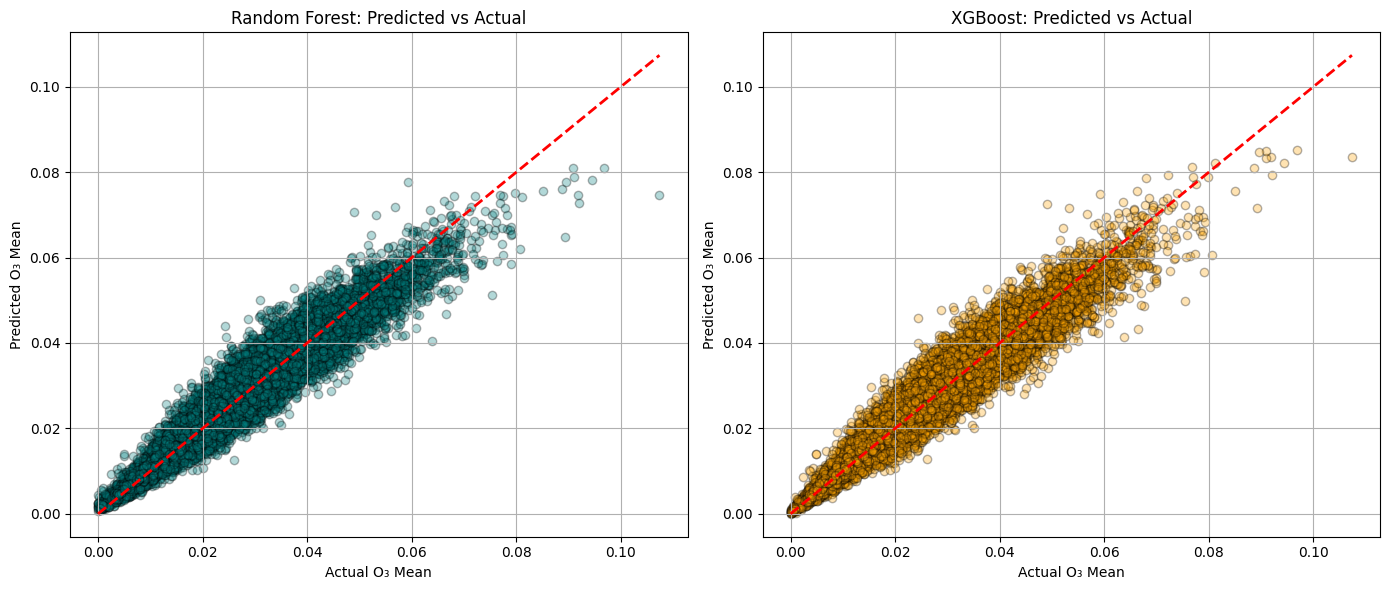

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Random Forest plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='teal', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual O₃ Mean')
plt.ylabel('Predicted O₃ Mean')
plt.title('Random Forest: Predicted vs Actual')
plt.grid(True)

# XGBoost plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='orange', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual O₃ Mean')
plt.ylabel('Predicted O₃ Mean')
plt.title('XGBoost: Predicted vs Actual')
plt.grid(True)

plt.tight_layout()
plt.show()

Feature Importance Plot

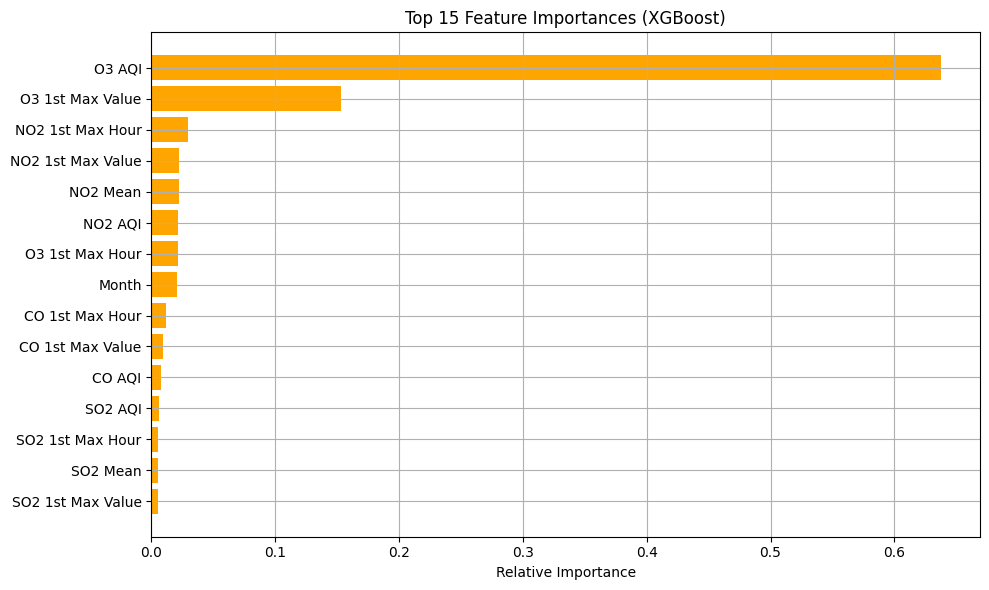

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the trained XGBoost model
importances = xgb.feature_importances_
feature_names = X.columns

# Sort and get top 15
indices = np.argsort(importances)[-15:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center', color='orange')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.tight_layout()
plt.grid(True)
plt.show()

Correlation Heatmap

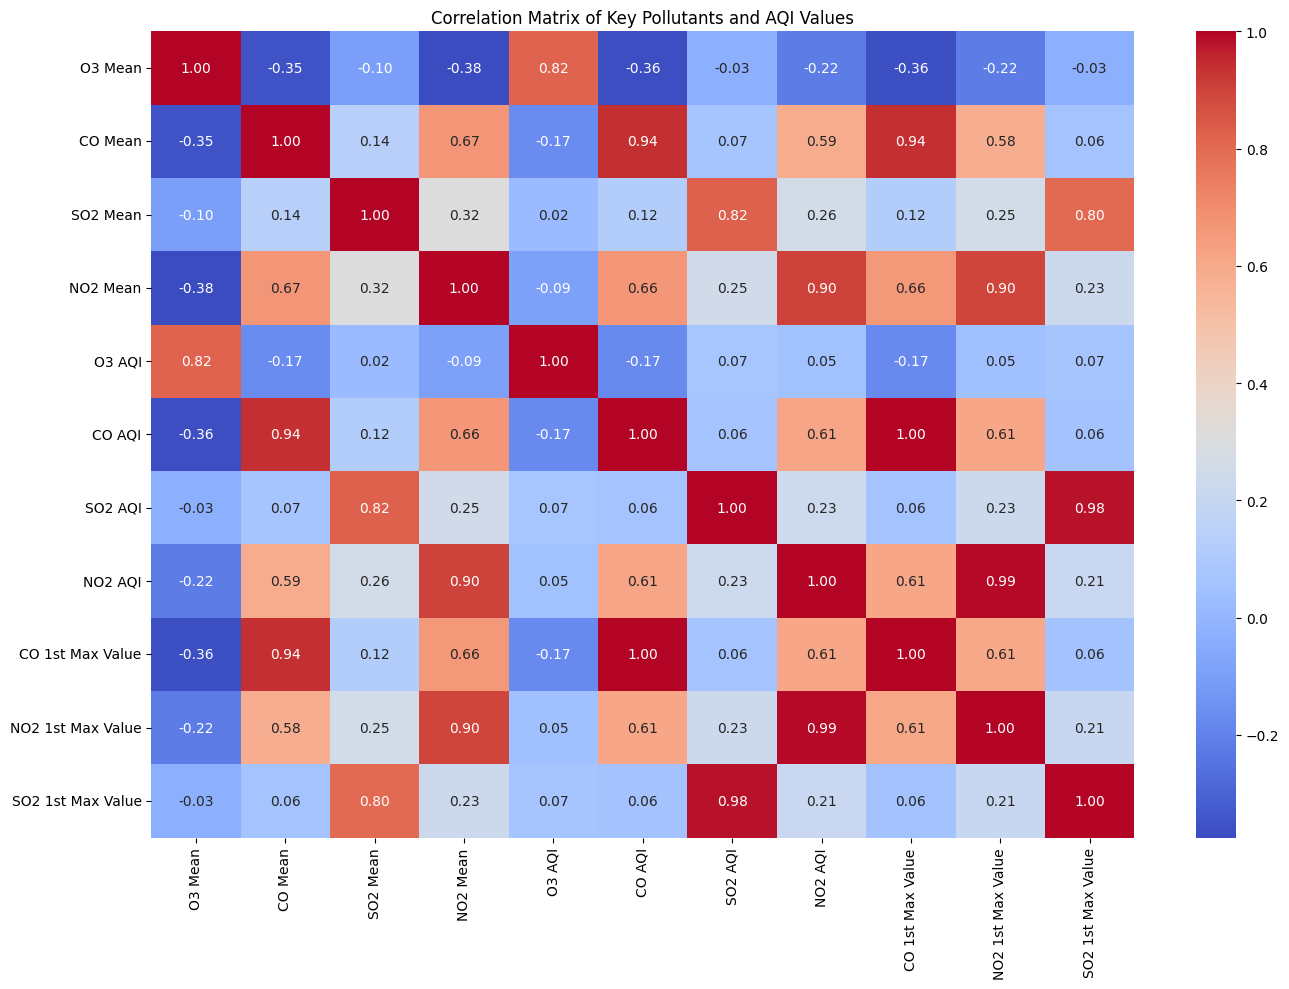

In [21]:
import seaborn as sns
plt.figure(figsize=(14, 10))
corr_matrix = df[[
    'O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean',
    'O3 AQI', 'CO AQI', 'SO2 AQI', 'NO2 AQI',
    'CO 1st Max Value', 'NO2 1st Max Value', 'SO2 1st Max Value'
]].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Key Pollutants and AQI Values")
plt.tight_layout()
plt.show()

O₃ Mean Distribution

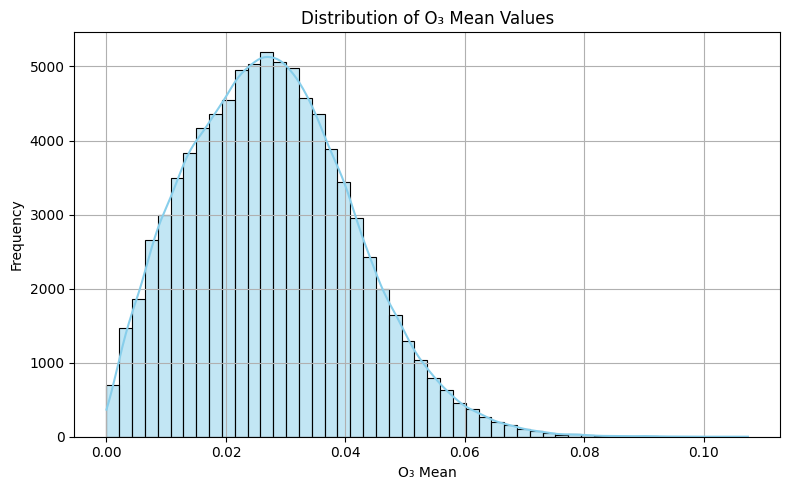

In [22]:
plt.figure(figsize=(8, 5))
sns.histplot(df['O3 Mean'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of O₃ Mean Values')
plt.xlabel('O₃ Mean')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

O₃ Mean Over Time (Line Plot)

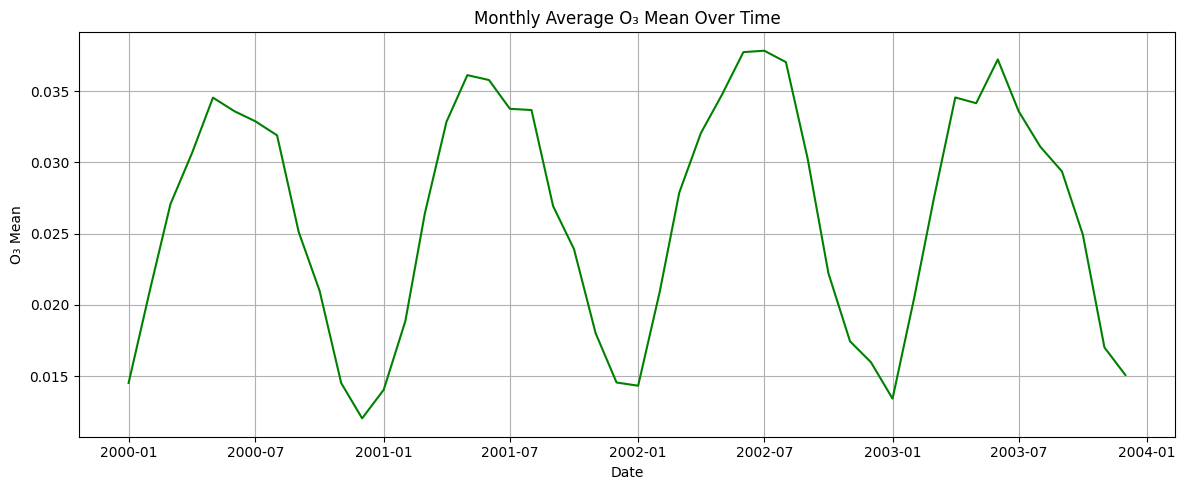

In [23]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Optional: group by month or year for smoother line
monthly_avg = df.groupby(df['Date'].dt.to_period('M'))['O3 Mean'].mean().reset_index()
monthly_avg['Date'] = monthly_avg['Date'].dt.to_timestamp()

plt.figure(figsize=(12, 5))
plt.plot(monthly_avg['Date'], monthly_avg['O3 Mean'], color='green')
plt.title('Monthly Average O₃ Mean Over Time')
plt.xlabel('Date')
plt.ylabel('O₃ Mean')
plt.grid(True)
plt.tight_layout()
plt.show()

Top 10 cities with highest average O₃

/tmp/ipython-input-3033042110.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities['O3 Mean'], y=top_cities.index, palette='flare')


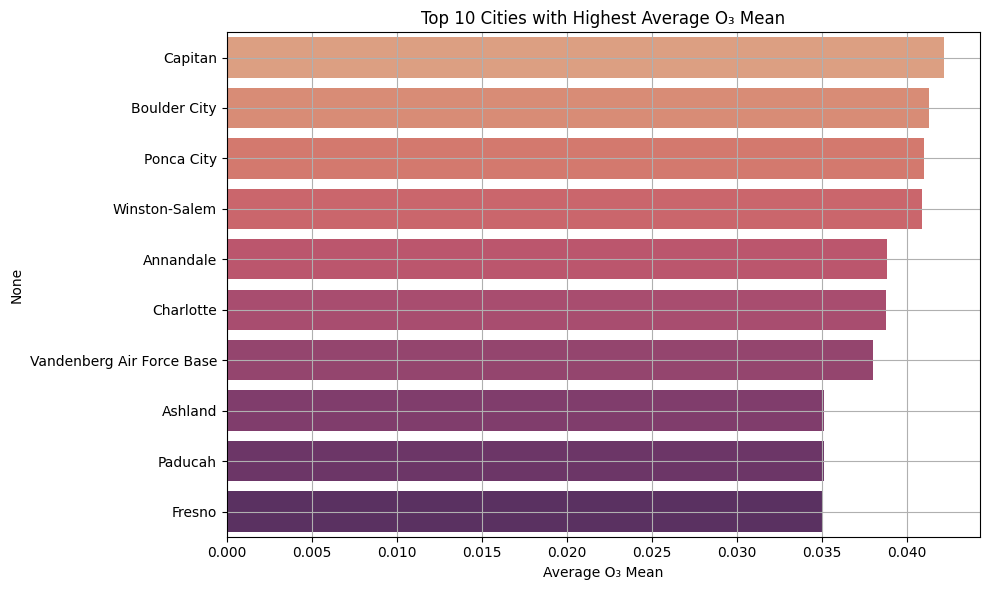

In [27]:
# Extract original city names from one-hot columns
city_columns = [col for col in df.columns if col.startswith('City_')]

# Create a DataFrame to store city-wise O₃ mean values
city_ozone_means = {}

# Loop through one-hot city columns
for city_col in city_columns:
    # Estimate mean O₃ where the city is active (i.e., value = 1)
    mask = df[city_col] == 1
    city_ozone_means[city_col.replace('City_', '')] = df.loc[mask, 'O3 Mean'].mean()

# Convert to DataFrame and sort
city_ozone_df = pd.DataFrame.from_dict(city_ozone_means, orient='index', columns=['O3 Mean'])
top_cities = city_ozone_df.sort_values(by='O3 Mean', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_cities['O3 Mean'], y=top_cities.index, palette='flare')
plt.title('Top 10 Cities with Highest Average O₃ Mean')
plt.xlabel('Average O₃ Mean')
plt.grid(True)
plt.tight_layout()
plt.show()